In [ ]:
!pip install Keras
!pip install vit-keras
!pip install tensorflow-addons
!pip install opendatasets
import opendatasets as od
import pandas

import os

import keras.preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras import layers
from keras import regularizers, activations
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, ZeroPadding2D
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator
from vit_keras import vit, utils


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/data of leaf diseases.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (3652).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (3653).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (3654).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (3655).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (3656).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (3657).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (3658).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (3659).JPG  
  inf

In [ ]:
import os
import shutil

# Define the source and destination directories
source_dir = "/content/Plant_leave_diseases_dataset_with_augmentation"
destination_dir = "/content/grape"

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Iterate through the files in the source directory
for filename in os.listdir(source_dir):
    # Check if the filename contains "Tomato"
    if "Grape" in filename:
        # Construct the full path for the source and destination files
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)

        # Move the file
        shutil.move(source_path, destination_path)


In [ ]:
base_dir = '/content/grape'

In [ ]:
import os
from collections import defaultdict

def count_images_in_folders(root_folder):
    image_count_per_folder = defaultdict(int)

    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)

        if os.path.isdir(folder_path):
            image_count = sum(1 for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')))
            image_count_per_folder[folder_name] = image_count

    return image_count_per_folder

# Specify the root folder where your image folders are located
root_folder_path = base_dir

image_counts = count_images_in_folders(root_folder_path)

# Print the results
for folder_name, count in image_counts.items():
    print(f"{folder_name}: {count} images")


Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape___Esca_(Black_Measles): 1383 images
Grape___Black_rot: 1180 images
Grape___healthy: 1000 images


In [ ]:
import os

def get_folder_names(directory_path):
    # Initialize an empty list to store folder names
    folder_names = []

    # Iterate over items in the specified directory
    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)

        # Check if the item is a directory
        if os.path.isdir(item_path):
          if item != '.ipynb_checkpoints':
            folder_names.append(item)

    return folder_names

# Specify the directory path for which you want to fetch folder names
directory_path = base_dir

# Call the function to get folder names in the specified directory
folders = get_folder_names(directory_path)

# Print the list of folder names
print("Folder Names:", folders)


Folder Names: ['Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___Esca_(Black_Measles)', 'Grape___Black_rot', 'Grape___healthy']


In [ ]:
len(folders)

4

In [ ]:
import os
import cv2

def invert_colors(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Invert the colors
    inverted_image = ~image

    # Save the inverted image
    cv2.imwrite(image_path, inverted_image)

def process_directory(directory):
    # Loop through the subdirectories
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)

        # Check if it is a directory
        if os.path.isdir(subdir_path):
            # Loop through the images in the subdirectory
            for filename in os.listdir(subdir_path):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png','.JPG')):
                    image_path = os.path.join(subdir_path, filename)
                    invert_colors(image_path)

# Specify the directory containing the subdirectories with images
main_directory = "/content/grape"

# Process the main directory
process_directory(main_directory)

print("Color inversion complete.")


Color inversion complete.


In [ ]:
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

val_dir = os.path.join(base_dir, 'val')
os.makedirs(val_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

In [ ]:

import shutil

# List of class folder names
class_folders = folders
# Split ratios (adjust these as needed)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

for folder in class_folders:
    source_folder = os.path.join(base_dir, folder)
    train_dest = os.path.join(train_dir, folder)
    val_dest = os.path.join(val_dir, folder)
    test_dest = os.path.join(test_dir, folder)

    os.makedirs(train_dest, exist_ok=True)
    os.makedirs(val_dest, exist_ok=True)
    os.makedirs(test_dest, exist_ok=True)

    filenames = os.listdir(source_folder)
    num_files = len(filenames)

    num_train = int(num_files * train_ratio)
    num_val = int(num_files * val_ratio)

    train_files = filenames[:num_train]
    val_files = filenames[num_train:num_train + num_val]
    test_files = filenames[num_train + num_val:]

    for file in train_files:
        src_path = os.path.join(source_folder, file)
        dest_path = os.path.join(train_dest, file)
        shutil.copy(src_path, dest_path)

    for file in val_files:
        src_path = os.path.join(source_folder, file)
        dest_path = os.path.join(val_dest, file)
        shutil.copy(src_path, dest_path)

    for file in test_files:
        src_path = os.path.join(source_folder, file)
        dest_path = os.path.join(test_dest, file)
        shutil.copy(src_path, dest_path)



In [ ]:

size = 224

batch_size = 32
target_size = (size,size)  # Adjust as needed

train_datagen = ImageDataGenerator(
    rescale=1./255
    )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False)

Found 3710 images belonging to 4 classes.
Found 463 images belonging to 4 classes.
Found 466 images belonging to 4 classes.


In [ ]:
test_labels = np.array(test_generator.labels)

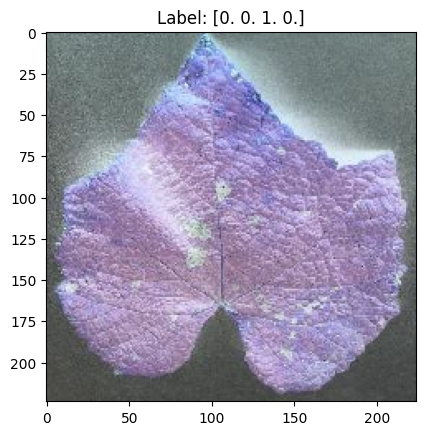

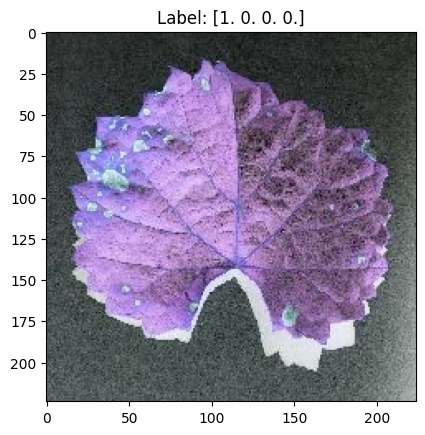

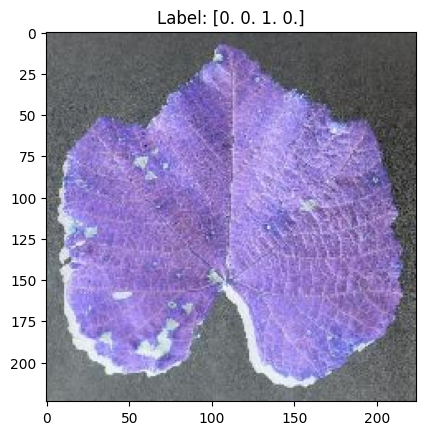

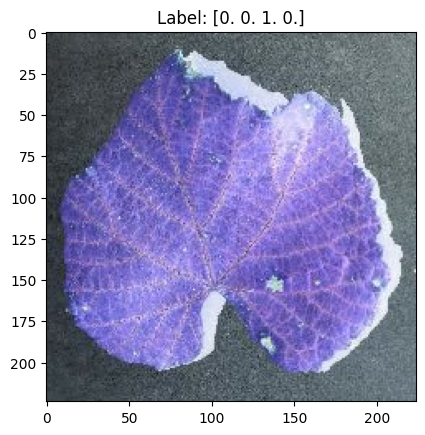

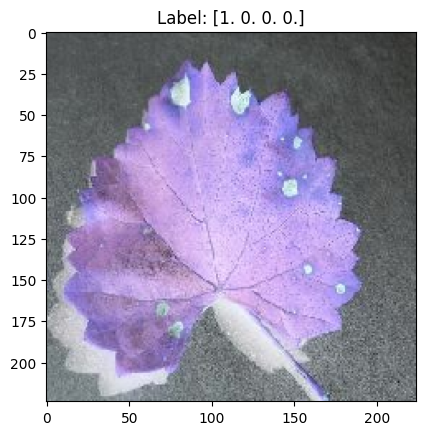

In [ ]:
# prompt: plot the images using train generator

import matplotlib.pyplot as plt

def plot_images(generator, num_images):
  for i in range(num_images):
    image, label = generator.next()
    plt.imshow(image[0])
    plt.title(f"Label: {label[0]}")
    plt.show()

plot_images(train_generator, 5)


## Models

## ViTBiT

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D
from vit_keras import vit
from tensorflow.keras.applications import MobileNetV2

def create_vit_mobilenet_model(input_shape, num_classes):
    vit_backbone = vit.vit_b16(
        image_size=input_shape[:2],
        include_top=False,
        pretrained=True,
        pretrained_top=False,
        classes=num_classes,
        weights="imagenet21k",
    )

    mobilenet_backbone = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        classes=num_classes,
    )

    mobilenet_backbone.trainable = False
    vit_backbone.trainable = False

    input_layer = layers.Input(shape=input_shape)

    # ViT Backbone
    vit_features = vit_backbone(input_layer)

    # MobileNetV2 Backbone
    mobilenet_features = mobilenet_backbone(input_layer)
    mobilenet_features = GlobalAveragePooling2D()(mobilenet_features)

    # Concatenate Features
    combined_features = layers.Concatenate()([vit_features, mobilenet_features])
    x = layers.Flatten()(combined_features)
    x = layers.BatchNormalization()(x)
    # Dense layer with Batch Normalization
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)

    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model


In [ ]:
input_shape = (size, size, 3) #input image shape
num_classes = 4  # Number of output classes


model = create_vit_mobilenet_model(input_shape, num_classes)


custom_optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=custom_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['input_3[0][0]']             
 tional)                                                                                          
                                                                                                  
 vit-b16 (Functional)        (None, 768)                  8638924   ['input_3[0][0]']             
                                                          8                                       
                               

In [ ]:
# prompt: add early stopping and reduce lr also import libraries

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-15)


In [ ]:
progess = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[reduce_lr]
)

Epoch 1/25
116/116 [==============================] - 95s 604ms/step - loss: 0.1774 - accuracy: 0.9375 - val_loss: 0.1058 - val_accuracy: 0.9676 - lr: 0.0010
Epoch 2/25
116/116 [==============================] - 68s 585ms/step - loss: 0.0631 - accuracy: 0.9779 - val_loss: 0.0375 - val_accuracy: 0.9849 - lr: 0.0010
Epoch 3/25
116/116 [==============================] - 67s 582ms/step - loss: 0.0423 - accuracy: 0.9873 - val_loss: 0.0522 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 4/25
116/116 [==============================] - 68s 583ms/step - loss: 0.0231 - accuracy: 0.9908 - val_loss: 0.0606 - val_accuracy: 0.9784 - lr: 0.0010
Epoch 5/25
116/116 [==============================] - 68s 589ms/step - loss: 0.0312 - accuracy: 0.9873 - val_loss: 0.0400 - val_accuracy: 0.9870 - lr: 0.0010
Epoch 6/25
116/116 [==============================] - 68s 583ms/step - loss: 0.0162 - accuracy: 0.9943 - val_loss: 0.0486 - val_accuracy: 0.9806 - lr: 1.0000e-04
Epoch 7/25
116/116 [============================

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

15/15 [==============================] - 8s 527ms/step - loss: 0.0270 - accuracy: 0.9914
Test Loss: 0.0270
Test Accuracy: 0.9914


15/15 [==============================] - 11s 466ms/step


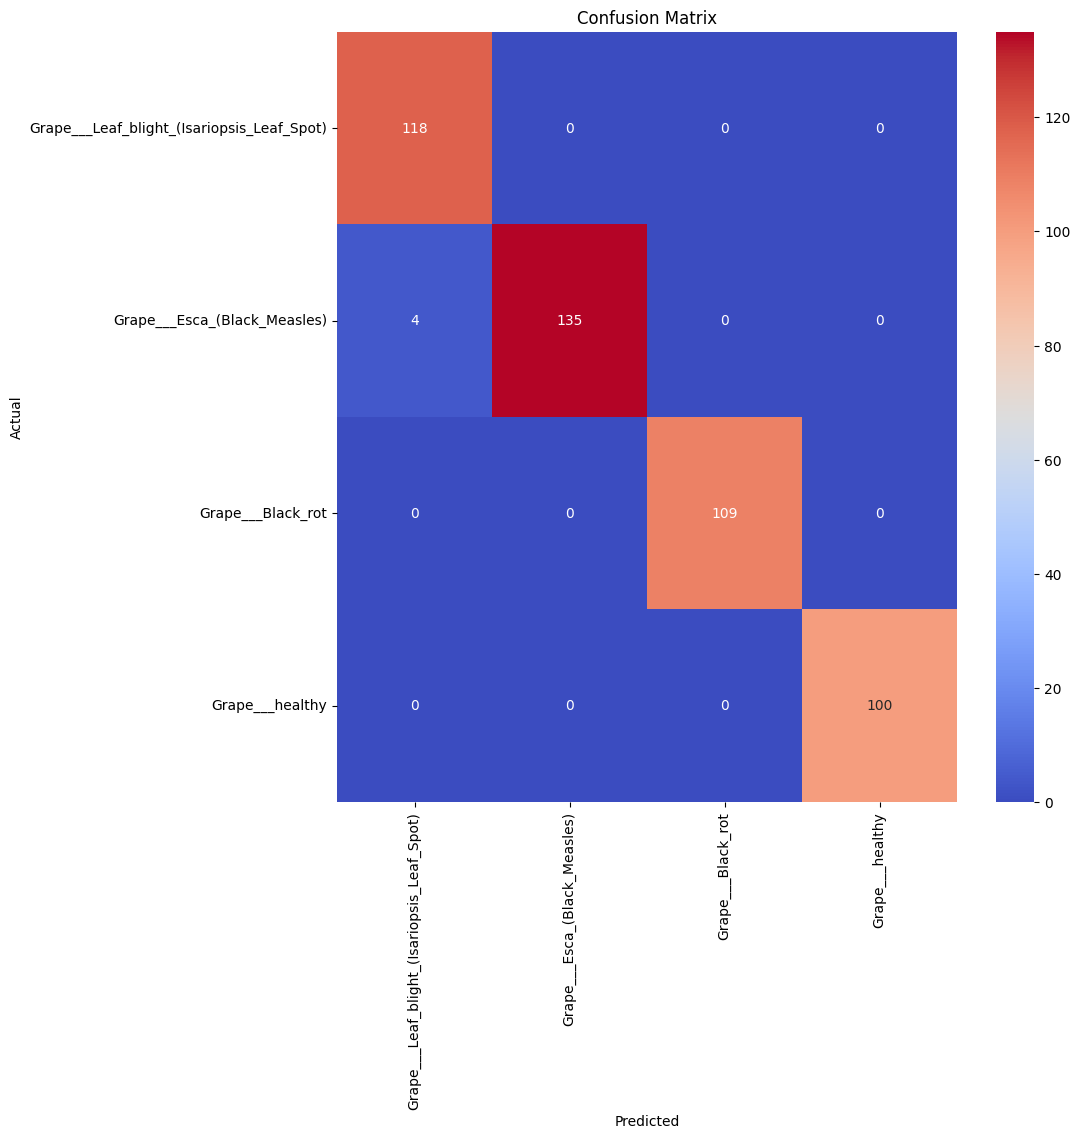

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have already trained and compiled your model
# train_ds is your training dataset

# Make predictions using the trained model
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the actual labels from the dataset

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(test_labels, predicted_labels)
classes = class_folders


import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

classes = class_folders

# Create a Seaborn heatmap for the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=classes, yticklabels=classes)  # Replace 'classes' with your class labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

In [ ]:
sum(acc)/len(acc)

0.9931752014160157

In [ ]:
sum(val_acc)/len(val_acc)

0.9839308977127075

In [ ]:
sum(loss)/len(loss)

0.020304538421332837

In [ ]:
sum(val_loss)/len(val_loss)

0.048290974497795104

In [ ]:
# prompt: print the precision recall and f1 score

from sklearn.metrics import classification_report
# Get the classification report
report = classification_report(test_labels, predicted_labels)

# Print the report
print(report)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98       118
           1       1.00      0.97      0.99       139
           2       1.00      1.00      1.00       109
           3       1.00      1.00      1.00       100

    accuracy                           0.99       466
   macro avg       0.99      0.99      0.99       466
weighted avg       0.99      0.99      0.99       466



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming test_labels and predicted_labels are your actual and predicted labels
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.9916977415042566
Recall: 0.9914163090128756
F1 Score: 0.9914251850923634


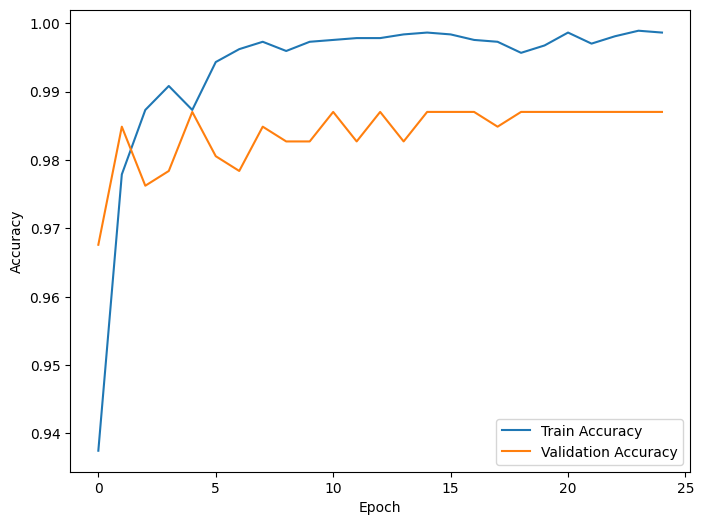

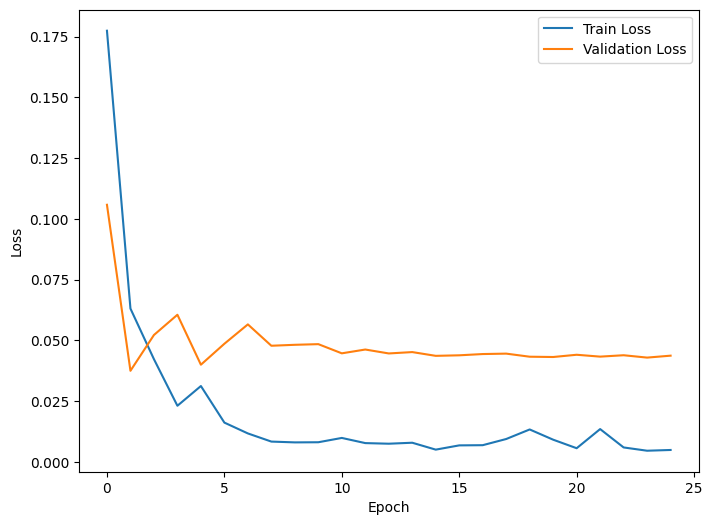

In [ ]:
# prompt: plot curves

# Plot the accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(progess.history['accuracy'], label='Train Accuracy')
plt.plot(progess.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.figure(figsize=(8, 6))
plt.plot(progess.history['loss'], label='Train Loss')
plt.plot(progess.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


15/15 [==============================] - 7s 464ms/step


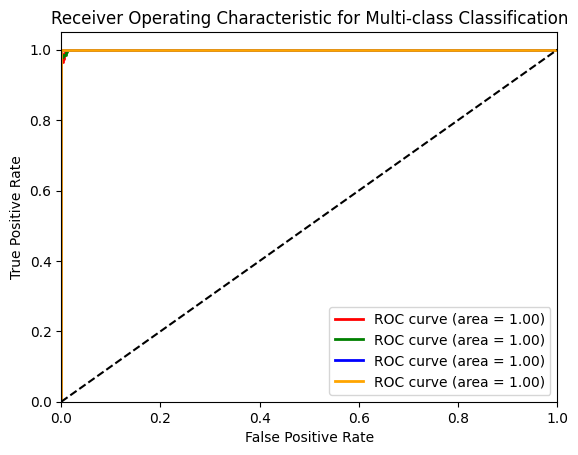

AUC scores:
Class 1: 0.9998051821546854
Class 2: 0.9998239940157966
Class 3: 1.0
Class 4: 1.0


In [ ]:
# prompt: ROC Curve display for deep learning

# Get predicted probabilities for each class
predictions = model.predict(test_generator)

# Get the actual labels
test_labels = np.array(test_generator.labels)

# Binarize the test labels
test_labels_bin = keras.utils.to_categorical(test_labels)

# Calculate ROC curves and AUC for each class
fpr = {}
tpr = {}
auc_scores = {}

n_classes = 4  # Adjust this to your number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], predictions[:, i])
    auc_scores[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
lw = 2
colors = ['red', 'green', 'blue', 'orange']  # Adjust colors for each class

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f)' % auc_scores[i])

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()

# Print AUC scores
print('AUC scores:')
for i, score in auc_scores.items():
    print(f'Class {i+1}: {score}')
